### Graph2: Bot with tools

In [6]:
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, START, END, add_messages
from dotenv import load_dotenv
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage
from tavily import TavilyClient
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_groq import ChatGroq


In [12]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
# llm = ChatGroq(model="llama-3.1-8b-instant")

class State(TypedDict):
    messages: Annotated[list, add_messages]

# tav_key = os.environ["TAVILY_API_KEY"]


search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm_with_tools = llm.bind_tools(tools=tools)

In [27]:
# res = llm_with_tools.invoke("what is the current weather in Vaasa, Finland?")
# print(res)

In [8]:
def chatbot(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def router(state:State):
    last_message = state["messages"][-1]

    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tool_call"
    else: 
        return "end"

In [9]:
tool_node = ToolNode(tools=tools)

graph = StateGraph(State)
graph.add_node("chatbot", chatbot)
graph.add_node("tools", tool_node)

graph.set_entry_point("chatbot")
graph.add_conditional_edges("chatbot", router, {"tool_call":"tools", "end":END})
graph.add_edge("tools", "chatbot")

app = graph.compile()

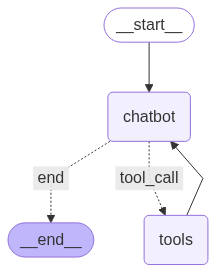

In [10]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:


while True:
    user_input = input("👤 You: ")
    if user_input.lower() == "exit":
        print("👋 Bye Bye!")
        break
        
    result = app.invoke({"messages": [HumanMessage(content=user_input)]})
    
    print(f"BOT🤖: {result['messages'][1].content}")

BOT🤖: 
BOT🤖: 
BOT🤖: There is no function for that request.
BOT🤖: 
👋 Bye Bye!
